## Naive Bayes Classifier From Scratch on Text Classification

In [373]:
#load the data

import pandas as pd
df=pd.read_csv('train_data.csv',index_col=0)
df.head()

,Sentence_id,New_Sentence,Type
0,GERRES15609,Author and/or Review architecture/design and o...,Responsibility
1,PHERES15784,Should be able to develop custom dynamic shape...,Responsibility
2,GERREQ10457,Experience in working crosslly with a larger ...,Requirement
3,GERSKL27235,"Previous business experience, including but no...",Skill
4,HONSSK18415,Delivering fast and right the first time.,SoftSkill


In [374]:
#drop Sentence_id
df.drop('Sentence_id',axis=1,inplace=True)

#check for null values
df.isnull().sum()

New_Sentence    1113
Type               0
dtype: int64

In [375]:
#drop null values

df.dropna(inplace=True)

In [376]:
print("Number of samples after dropping null values: ",df.shape[0])

Number of samples after dropping null values:  59002


In [377]:
#randomly select 20% of the data as test data

test=df.sample(frac=0.2)

#drop the test data from the train data

train_df=df.drop(test.index)


In [378]:
print("Number of samples in the train data: ",df.shape[0])
print("Number of samples in the test data: ",test.shape[0])

Number of samples in the train data:  59002
Number of samples in the test data:  11800


In [379]:
df.head()

,New_Sentence,Type
0,Author and/or Review architecture/design and o...,Responsibility
1,Should be able to develop custom dynamic shape...,Responsibility
2,Experience in working crosslly with a larger ...,Requirement
3,"Previous business experience, including but no...",Skill
4,Delivering fast and right the first time.,SoftSkill


In [380]:
# calculate class probabilities in the train data
prior=train_df['Type'].value_counts()/train_df.shape[0]
#convert into a dictionary
prior=prior.to_dict()
prior

{'Responsibility': 0.2597771280877929,
 'Requirement': 0.23448158976314562,
 'SoftSkill': 0.15891275793398585,
 'Experience': 0.15306554806999703,
 'Skill': 0.11613914664632854,
 'Education': 0.07762382949875005}

In [381]:
#build a nested dictionary to store the conditional probabilitiess
#keys are the classes
#values are dictionaries with keys as the words and values as the count of the words in the class
def calculate_likelihoods(train_df,prior,alpha=0):
    likelihoods={}
    for c in prior.keys():
        likelihoods[c]={}
        for sentence in train_df[train_df['Type']==c]['New_Sentence']:
            # sentence=sentence.lower()
            # import re
            # words=set(re.findall(r'\w+',sentence))
            #remove stop words
            # from nltk.corpus import stopwords
            # stop_words=set(stopwords.words('english'))
            # words=[word for word in words if word not in stop_words]
            for word in set(sentence.split()):
                #add the word to the dictionary with count 1 if it is not present
                #else increment the count by 1
                likelihoods[c][word]=likelihoods[c].get(word,0)+1
    #remove the words with count less than 3
    # for c in likelihoods.keys():
    #     likelihoods[c]={k:v for k,v in likelihoods[c].items() if v>=3}
    #convert the counts into probabilities
    for c in likelihoods.keys():
        total_count=sum(likelihoods[c].values())
        # print("Total number of words in class ",c," is ",total_count)
        for word in likelihoods[c].keys():
            #add alpha to the count to avoid zero probabilities
            likelihoods[c][word]=(likelihoods[c][word]+alpha)/(total_count+alpha*len(likelihoods[c].keys()))
    return likelihoods

In [382]:
likelihoods=calculate_likelihoods(train_df,prior,alpha=0)

In [383]:
#function to predict the class of a sentence

def predict(sentence,alpha=0):
    #split the sentence into words
    words=sentence.split()
    #initialize the class probabilities
    class_probabilities={}
    #iterate over all the classes
    for c in prior.keys():
        #initialize the class probability with the prior probability of the class
        class_probabilities[c]=prior[c]
        #iterate over all the words in the sentence
        for word in words:
            #if the word is present in the class, multiply the class probability
            #with the conditional probability of the word given the class
            if word in likelihoods[c].keys():
                class_probabilities[c]*=likelihoods[c][word]
            else:
                #multiply with zero
                class_probabilities[c]*=alpha/(sum(likelihoods[c].values())+alpha*len(likelihoods[c].keys()))
    #return the class with the maximum probability
    return max(class_probabilities,key=class_probabilities.get)

#predict the class of the test data
test['Predicted']=test['New_Sentence'].apply(predict)

#calculate the accuracy

accuracy=(test['Type']==test['Predicted']).sum()/test.shape[0]

print("Accuracy of the model is: ",accuracy)

Accuracy of the model is:  0.5435593220338983


Apply Laplace Smoothing to the Naive Bayes Classifier

In [384]:
#apply different values of alpha and compare the accuracies
accuracies=[]
alphas=[0,1,5,10,50,100,1000]
for alpha in alphas:
    likelihoods=calculate_likelihoods(train_df,prior,alpha)
    test['Predicted']=test['New_Sentence'].apply(predict,alpha=alpha)
    accuracy=(test['Type']==test['Predicted']).sum()/test.shape[0]
    accuracies.append(accuracy)
    print("Accuracy of the model with alpha ",alpha," is ",round(accuracy,2))

Accuracy of the model with alpha  0  is  0.54
Accuracy of the model with alpha  1  is  0.61
Accuracy of the model with alpha  5  is  0.6
Accuracy of the model with alpha  10  is  0.58
Accuracy of the model with alpha  50  is  0.43
Accuracy of the model with alpha  100  is  0.36
Accuracy of the model with alpha  1000  is  0.17


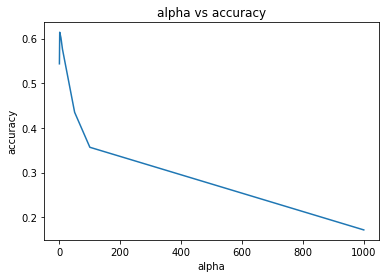

In [385]:
# #plot alpha vs accuracy

import matplotlib.pyplot as plt
plt.plot(alphas,accuracies)
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.title('alpha vs accuracy')
plt.show()


Top 10 words that predict each class


In [386]:
for cls in likelihoods.keys():
    print("Top 10 words in class ",cls," are: ")
    words=[word[0] for word in sorted(likelihoods[cls].items(),key=lambda x:x[1],reverse=True)[:10]]

Top 10 words in class  Responsibility  are: 
['and', 'to', 'the', 'of', 'with', 'for', 'in', 'a', 'will', 'on']

Top 10 words in class  Requirement  are: 
['and', 'to', 'in', 'of', 'with', 'a', 'experience', 'the', 'Experience', 'or']

Top 10 words in class  SoftSkill  are: 
['and', 'to', 'with', 'in', 'a', 'skills.', 'skills', 'communication', '.', 'of']

Top 10 words in class  Experience  are: 
['years', 'of', 'experience', 'in', 'and', 'with', 'or', 'a', 'experience.', 'Minimum']

Top 10 words in class  Skill  are: 
['and', 'in', 'of', 'with', 'Experience', 'experience', '.', 'to', 'a', 'knowledge']

Top 10 words in class  Education  are: 
['in', 'or', 'degree', 'Bachelors', 'Degree', 'Engineering', 'a', '.', 'Computer', 'of']



In [387]:
#load test_data.csv and predict the classes of the sentences and save

test_data=pd.read_csv('test_data.csv',index_col=0)
test_data.head()

,Sentence_id,New_Sentence
0,UAERES16346,Collaborate across all of DB&T practices and o...
1,COGREQ15586,Strong technology expertise in Identity and A...
2,UAEREQ12722,Strong knowledge on Service Virtualization.
3,COGSKL29155,Architect scalable data processing and analyti...
4,PHERES12551,"Map client organization, build outstanding rel..."


In [388]:
test_data.dropna(inplace=True)

In [389]:
test_data['Predicted']=test_data['New_Sentence'].apply(predict)

In [390]:
test_data.head()

,Sentence_id,New_Sentence,Predicted
0,UAERES16346,Collaborate across all of DB&T practices and o...,Responsibility
1,COGREQ15586,Strong technology expertise in Identity and A...,Experience
2,UAEREQ12722,Strong knowledge on Service Virtualization.,Experience
3,COGSKL29155,Architect scalable data processing and analyti...,Experience
4,PHERES12551,"Map client organization, build outstanding rel...",Responsibility


In [391]:
#save the predictions

test_data.to_csv('predictions.csv')